In [32]:
# pip install -U memory_profiler

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random
import enum
import time
from memory_profiler import profile
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Задание 1

Решить линейную регрессию — найти прямую, которая описывает зависимость

N - количество осей (размерность) <br>
M - количество точек <br>
minValue - минимальное значение для иксов <br>
maxValue - максимальное значение для иксов

In [34]:
N = 1
M = 30
minValue = 0
maxValue = 5
beta_1 = 0.9
beta_2 = 0.999
batch = random.randint(1, M)

class TypeOfOptimisation(enum.Enum):
    none = 0
    momentum = 1
    Nesterov = 2
    RMSProp = 3
    AdaGrad = 4
    Adam = 5

a = np.array([1, 2])
print(np.sqrt(a))

[1.         1.41421356]


In [35]:
def y_regression(B, X):
    return np.sum(X * B)


B_reg = []
for ind in range(N + 1):
    bi = random.randint(-maxValue, maxValue)
    B_reg.append(bi)
B_reg = np.array(B_reg, dtype='float64')
print(B_reg)
XM = []
YM = []
YR = []
for ind in range(M):
    X = [1]
    for j in range(N):
        X.append(ind)
    X = np.array(X)
    rand_delta = random.randint(-maxValue, maxValue)
    Y_act = y_regression(B_reg, X) + 0.5 * rand_delta
    YM.append(Y_act)
    XM.append(np.array(X))
XM = np.array(XM, dtype='float64')
YM = np.array(YM)

def runSGD(batch, typeOfOptimisation, withNormalization, lr, eps):
    B_start = np.array([0] * (N + 1), dtype='float64')
    YR = np.array([0] * M, dtype='float64')
    global calculations
    start = time.time()
    calculations = 0
    if withNormalization:
        X_norm = ZNormalization(XM)
        Y_norm = (YM - np.mean(YM)) / np.std(YM)
        BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
        BF_norm, \
        errors_norm, \
        YF_norm, \
        iterations = gradient_descent(batch,
                                      X_norm,
                                      Y_norm,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      TypeOfOptimisation.none,
                                      with_normalization=True)
        print()
        print("batch:                   ", batch)
        print(errors_norm[0], errors_norm[len(errors_norm) - 1])
        print("actual coefficients:     ", BA_start)
        print("calculated coefficients: ", BF_norm)
        print("number of iterations:    ", iterations)
        print("number of calculations: ", calculations)
        print("execution time: ", (time.time() - start) * 1000, "ms")
        draw_graph(X_norm, Y_norm, YF_norm, batch, withNormalization, typeOfOptimisation)
        draw_errors_graphic(errors_norm, iterations, batch, withNormalization, typeOfOptimisation)
    else:
        B_final, \
        errors, \
        YF, \
        iterations = gradient_descent(batch,
                                      XM,
                                      YM,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      typeOfOptimisation,
                                      with_normalization=False)
        print()
        print("batch:                   ", batch)
        print(errors[0], errors[len(errors) - 1])
        print("actual coefficients:     ", B_reg)
        print("calculated coefficients: ", B_final)
        print("number of iterations:    ", iterations)
        print("number of calculations: ", calculations)
        print("execution time: ", (time.time() - start) * 1000, "ms")
        draw_graph(XM, YM, YF, batch, withNormalization, typeOfOptimisation)
        draw_errors_graphic(errors, iterations, batch, withNormalization, typeOfOptimisation)


[4. 1.]



batch:                    1
17.424833333333332 2.0525768900427264
actual coefficients:      [4. 1.]
calculated coefficients:  [0.07911938 1.25346365]
number of iterations:     25
number of calculations:  52
execution time:  10.759115219116211 ms
peak memory: 121.35 MiB, increment: 2.25 MiB

batch:                    15.0
46.06906666666666 1.0778272521522659e+23
actual coefficients:      [4. 1.]
calculated coefficients:  [4.10495985e+20 7.40498133e+21]
number of iterations:     43
number of calculations:  1317
execution time:  12.386798858642578 ms
peak memory: 120.59 MiB, increment: 0.07 MiB

batch:                    30
131.09786666666668 1.690602198221397e+23
actual coefficients:      [4. 1.]
calculated coefficients:  [5.91316825e+20 1.16185450e+22]
number of iterations:     25
number of calculations:  1545
execution time:  13.073921203613281 ms
peak memory: 120.54 MiB, increment: 0.00 MiB


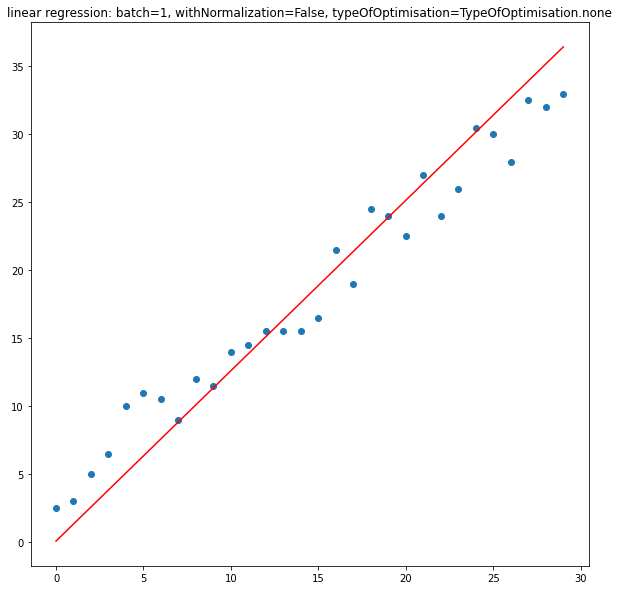

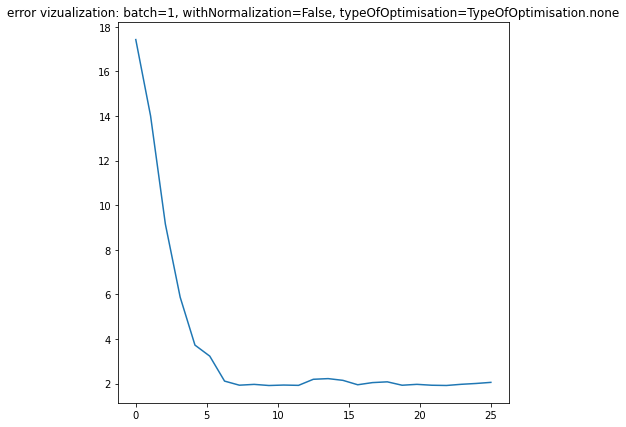

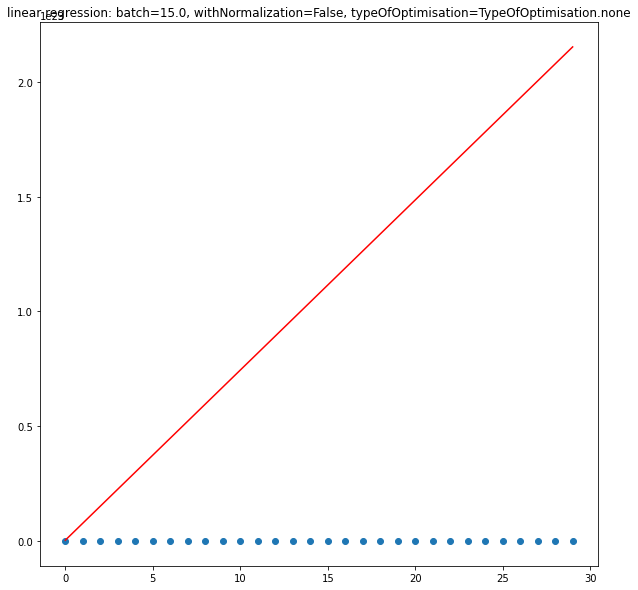

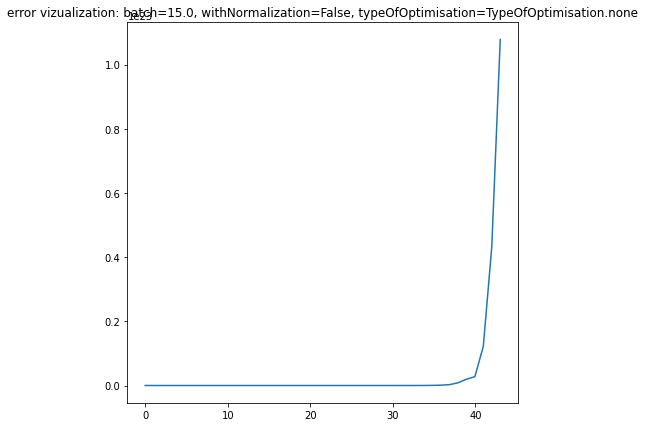

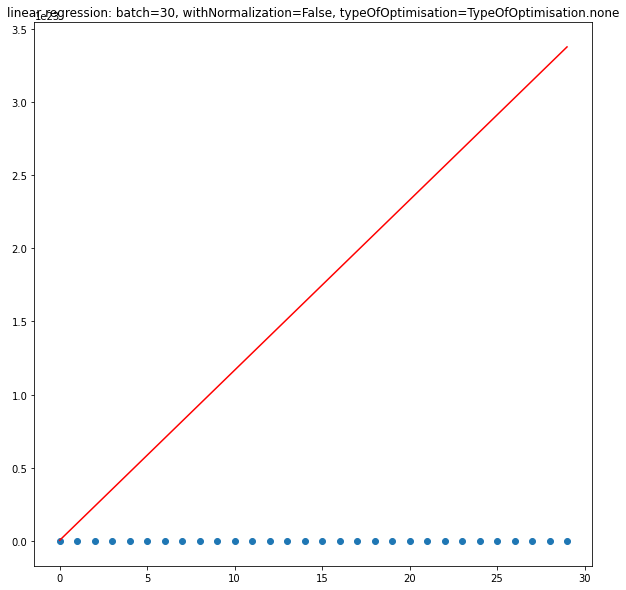

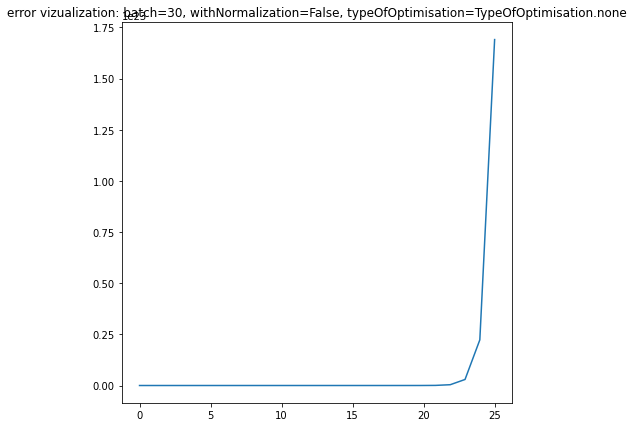

In [36]:
def mean_error(Y_act, Y_reg):
    return np.sum(abs(Y_act - Y_reg)) / M


def stopping_criteria(previous, current, eps):
    return abs(previous - current) < eps


def gradient(nums, XM, YR, YM):
    global calculations
    grad = []
    for i in range(N + 1):
        xi = 0
        for k in range(len(nums)):
            xi += XM[nums[k]][i] * (YR[nums[k]] - YM[nums[k]])
            calculations = calculations + 1
            if xi > 1e25:
                return np.array([0] * (N + 1), dtype='float64')
        grad.append(xi)
    return np.array(grad)

def gradient_descent(batch, XM, YM, YR, B_reg, lr, eps, type_of_optimisation, with_normalization):
    # a = [0] * 100000000
    previous_error = 0
    grad = np.array([0] * (N + 1), dtype='float64')
    previous_gradient = np.array([0] * (N + 1), dtype='float64')
    m_adam = np.array([0] * (N + 1), dtype='float64')
    v_adam = np.array([0] * (N + 1), dtype='float64')
    errors = []
    iterations = 0
    global calculations
    while True:
        nums = set()
        while len(nums) != batch:
            x = random.randint(0, M - 1)
            if x not in nums:
                nums.add(x)
        nums = np.array(list(nums))

        # :NOTE: optimisations
        if type_of_optimisation == TypeOfOptimisation.none:
            grad = gradient(nums, XM, YR, YM)
        elif type_of_optimisation == TypeOfOptimisation.momentum:
            grad = gradient(nums, XM, YR, YM)
            grad += gamma * previous_gradient
            calculations = calculations + 1
        elif type_of_optimisation == TypeOfOptimisation.Nesterov:
            B_prev = B_reg - lr * previous_gradient
            YR_new = [0] * M
            for i in range(M):
                YR_new[i] = y_regression(B_prev, XM[i])
            grad = gradient(nums, XM, np.array(YR_new), YM)
            grad += gamma * previous_gradient
            calculations = calculations + 2 + M
        elif type_of_optimisation == TypeOfOptimisation.AdaGrad:
            grad = gradient(nums, XM, YR, YM)
            new_grad = previous_gradient + np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
            calculations = calculations + 2
        elif type_of_optimisation == TypeOfOptimisation.RMSProp:
            grad = gradient(nums, XM, YR, YM)
            new_grad = gamma * previous_gradient + (1 - gamma) * np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
            calculations = calculations + 2
        elif type_of_optimisation == TypeOfOptimisation.Adam:
            grad = gradient(nums, XM, YR, YM)
            m_adam = beta_1 * m_adam + (1 - beta_1) * grad
            v_adam = beta_2 * v_adam + (1 - beta_2) * np.square(grad)
            m = m_adam / (1 - beta_1)
            v = v_adam / (1 - beta_2)
            grad = m / np.sqrt(abs(v + eps))
            calculations = calculations + 5
        B_reg -= lr * grad

        for i in range(M):
            YR[i] = y_regression(B_reg, XM[i])
        if stopping_criteria(previous_error, mean_error(YM, YR), eps):
            break
        previous_error = mean_error(YM, YR)
        previous_gradient = grad
        errors.append(previous_error)
        iterations += 1
    return B_reg, errors, YR, iterations


def draw_graph(XM, YM, YF, batch, withNormalization, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF, color='red')
    title = 'linear regression: batch=' + str(batch) + \
            ', withNormalization=' + str(withNormalization) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()


def draw_errors_graphic(E, iterations, batch, withNormalization, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    i = np.linspace(0, iterations, iterations)
    plt.plot(i, E)
    title = 'error vizualization: batch=' + str(batch) + \
            ', withNormalization=' + str(withNormalization) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()

%memit runSGD(1, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)
%memit runSGD(M / 2, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)
%memit runSGD(M, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)

# Задание 2


batch:                    1
0.8571707472652232 0.1476524519573325
actual coefficients:      [ 1. -1.]
calculated coefficients:  [0.01677497 0.96244495]
number of iterations:     402
number of calculations:  806
execution time:  72.68786430358887 ms
peak memory: 120.54 MiB, increment: 0.00 MiB

batch:                    15.0
0.7400291025078253 0.14520355026239973
actual coefficients:      [ 1. -1.]
calculated coefficients:  [0.01013147 0.99278894]
number of iterations:     346
number of calculations:  10410
execution time:  86.22503280639648 ms
peak memory: 120.55 MiB, increment: 0.00 MiB

batch:                    30
0.621596419236657 0.1437104128792822
actual coefficients:      [ 1. -1.]
calculated coefficients:  [-1.22679644e-16  9.85412604e-01]
number of iterations:     25
number of calculations:  1560
execution time:  12.902975082397461 ms
peak memory: 120.55 MiB, increment: 0.00 MiB


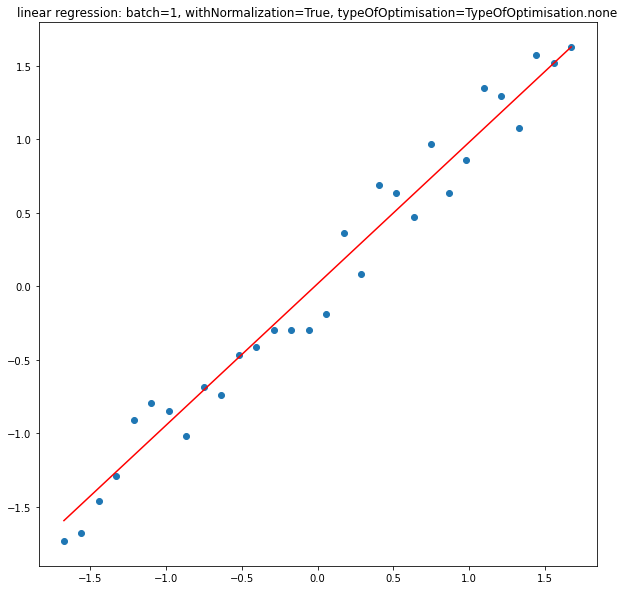

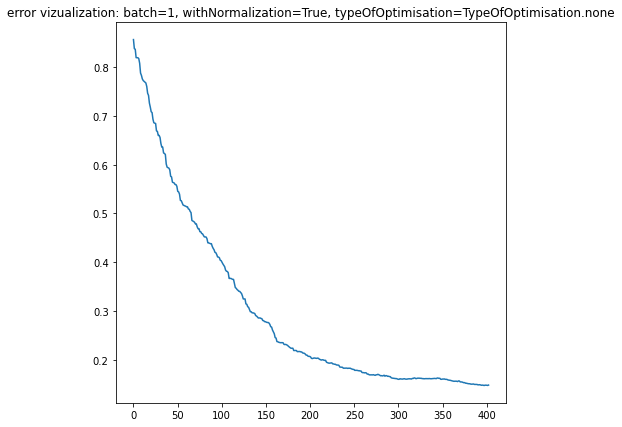

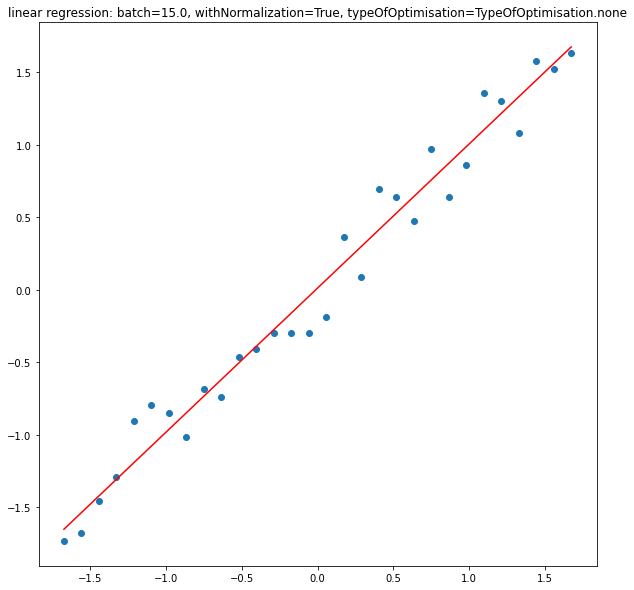

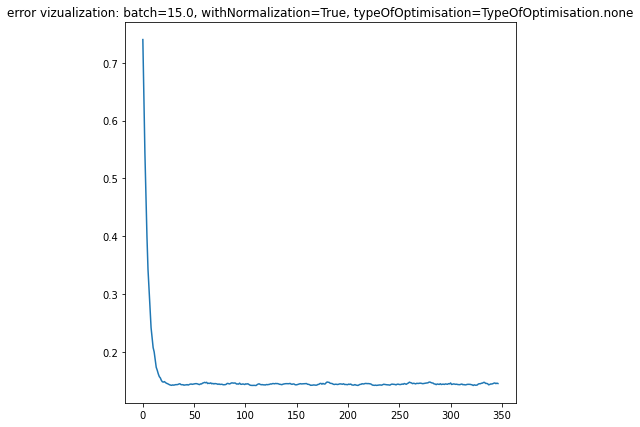

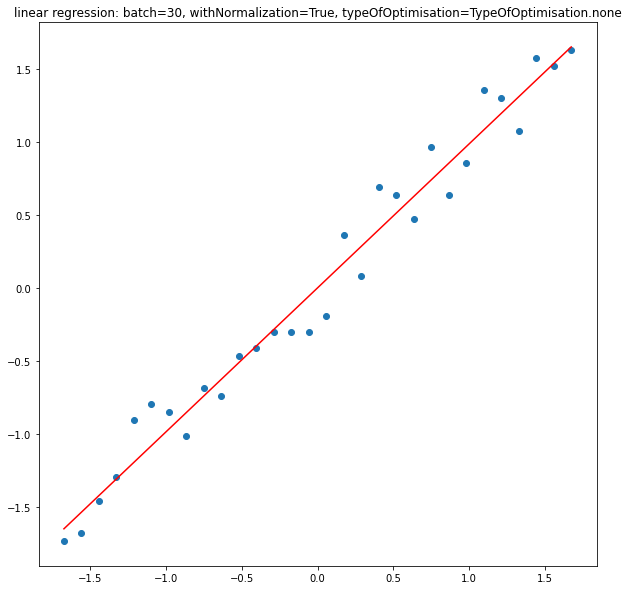

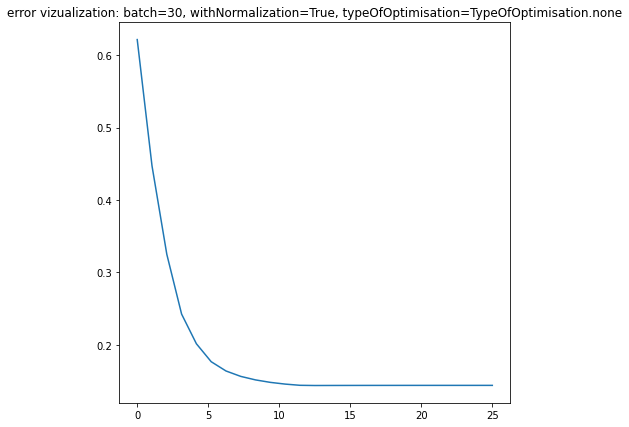

In [37]:
def ZNormalization(XM):
    X = XM.T
    for i in range(1, N + 1):
        X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
    return X.T


# print(XM)
%memit runSGD(1, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)
%memit runSGD(M / 2, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)

# Задание 3

### Метод моментов

Смысл заключается в том, что мы на каждом шаге прибавляем к значению градиента
предыдущий градиент умноженный на константу. Это позволяет градиентному спуску не застревать
в локальных минимумах.


batch:                    1
17.268817204301076 1.31154806318722
actual coefficients:      [4. 1.]
calculated coefficients:  [17.99854485  8.80126014]
number of iterations:     3131
number of calculations:  9396
execution time:  552.3040294647217 ms
peak memory: 121.39 MiB, increment: 0.84 MiB

batch:                    15.0
5.9666666666666694 1.7821247069905983
actual coefficients:      [4. 1.]
calculated coefficients:  [19.62251046  8.8141848 ]
number of iterations:     3440
number of calculations:  106671
execution time:  902.2159576416016 ms
peak memory: 122.70 MiB, increment: 5.25 MiB

batch:                    30
36.466666666666676 1.303327681550292
actual coefficients:      [4. 1.]
calculated coefficients:  [18.23420234  8.93700073]
number of iterations:     187
number of calculations:  11468
execution time:  88.64521980285645 ms
peak memory: 121.16 MiB, increment: 6.11 MiB

batch:                    1
0.6393567071273359 0.14376620021262745
actual coefficients:      [ 1. -1.]
ca

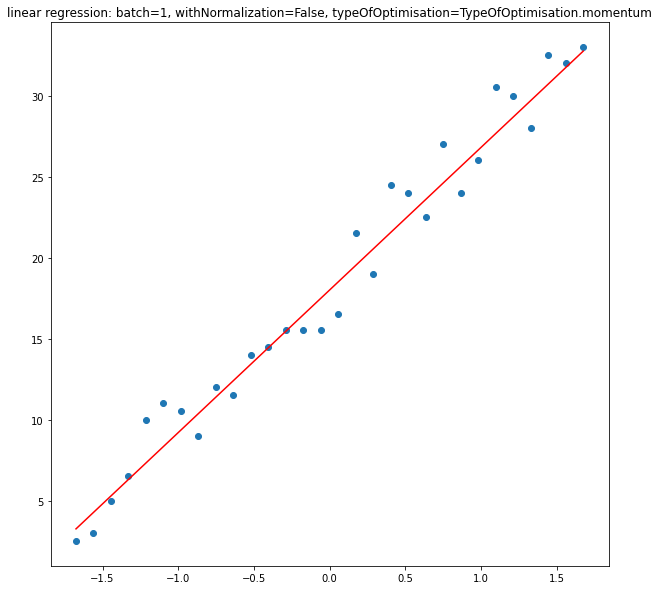

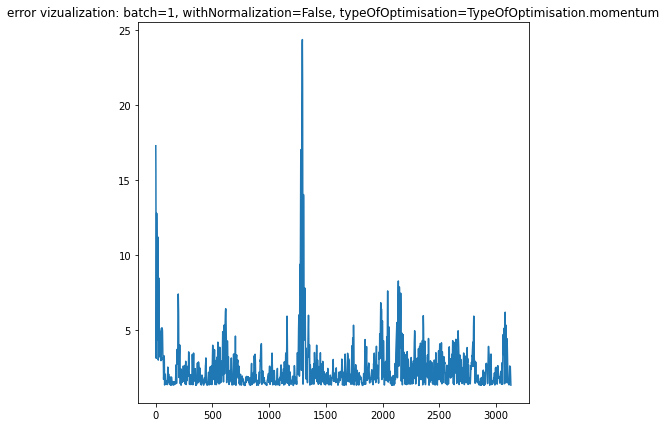

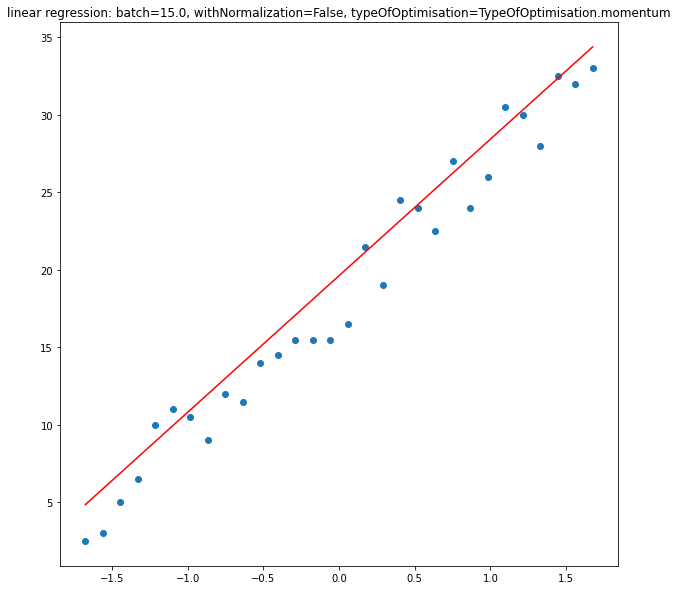

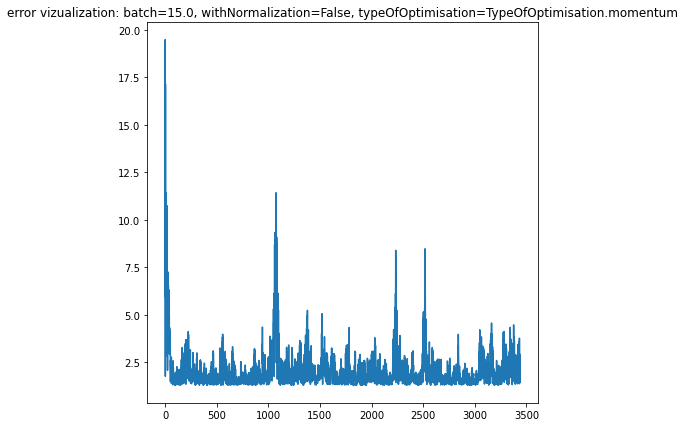

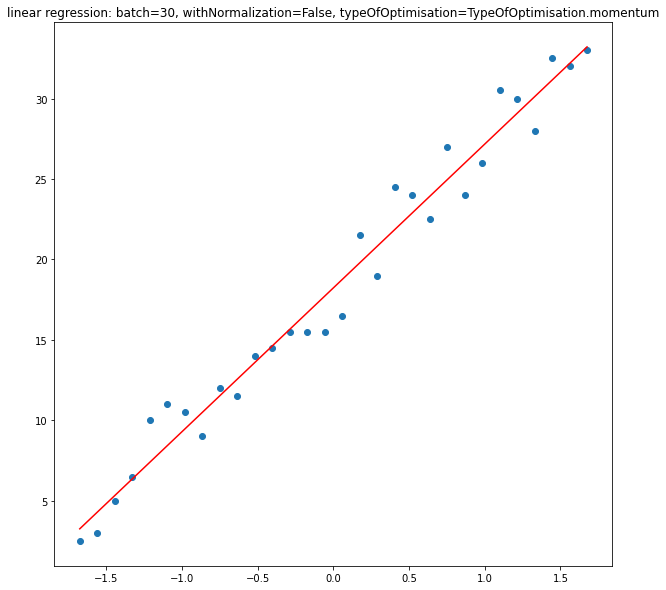

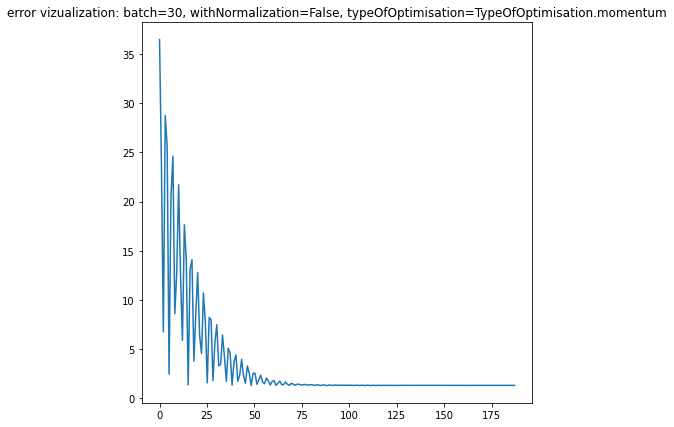

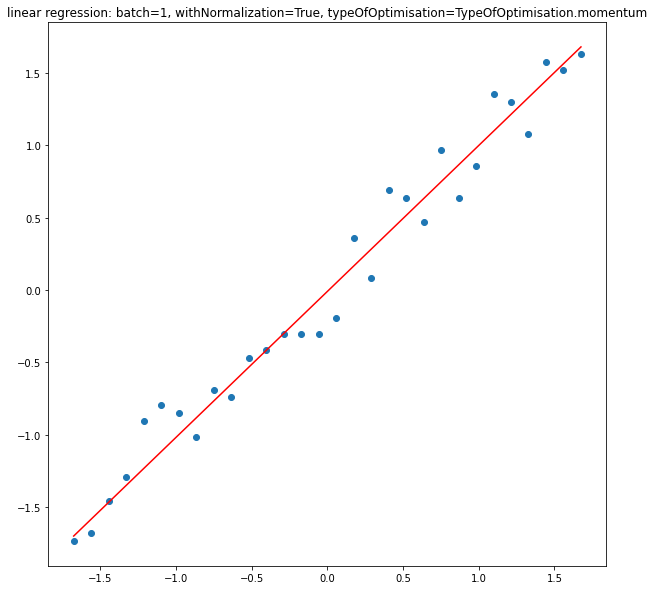

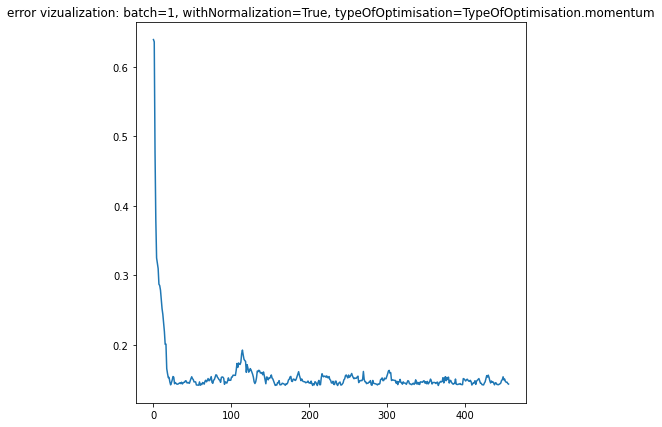

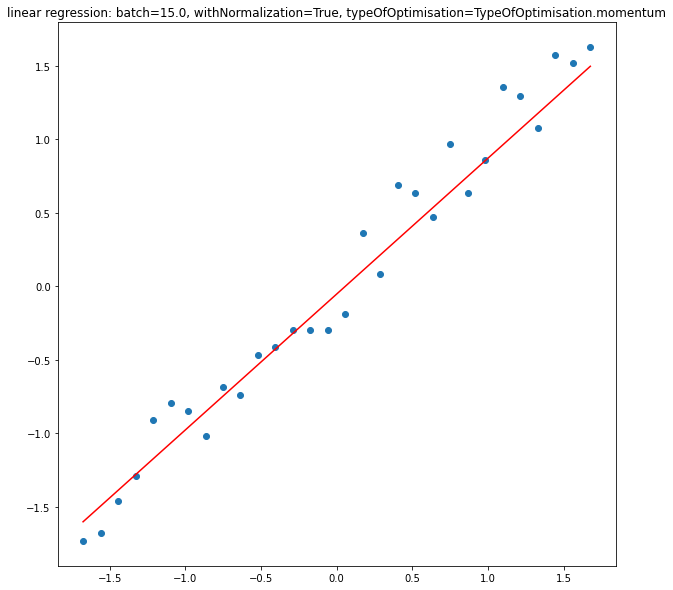

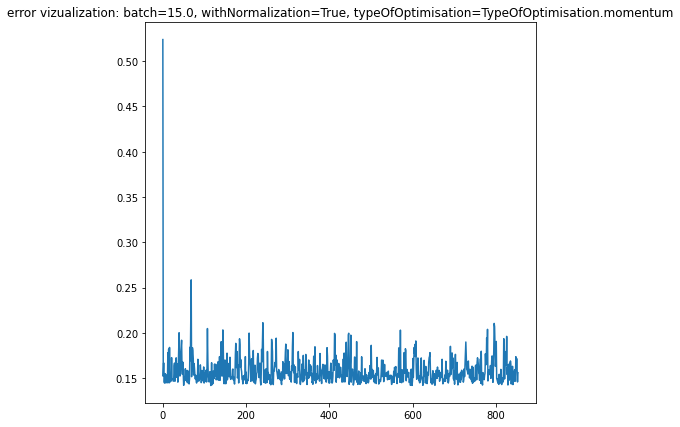

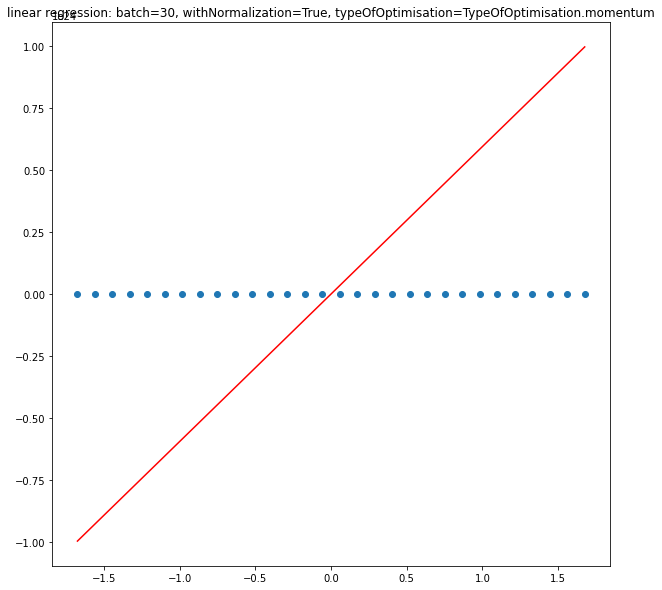

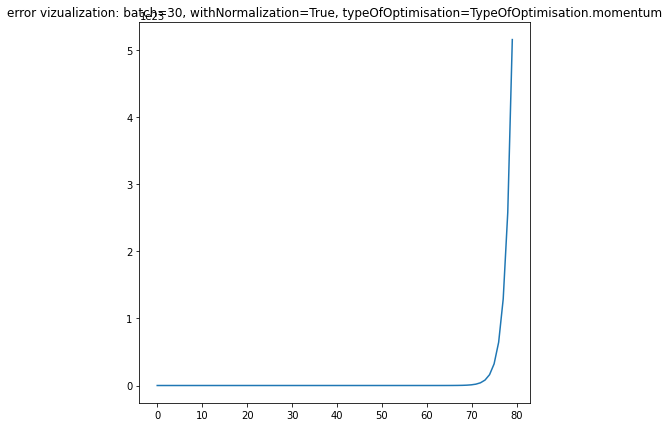

In [38]:
gamma = 0.9

%memit runSGD(1, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M / 2, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)

### Метод Нестерова

Здесь используется тот же смысл, как и в методе моментов, только градиент мы считаем не от текущей точки,
а от следующей (как бы заглядывая вперед). Дает более быструю сходимость, чем метод моментов.


batch:                    1
15.633333333333331 1.6571370973285238
actual coefficients:      [4. 1.]
calculated coefficients:  [19.41725068  9.25432386]
number of iterations:     131
number of calculations:  4488
execution time:  58.89701843261719 ms
peak memory: 121.90 MiB, increment: 0.01 MiB

batch:                    15.0
13.63105672969967 5.605398821500255e+24
actual coefficients:      [4. 1.]
calculated coefficients:  [-3.74111769e+24  5.64520496e+24]
number of iterations:     448
number of calculations:  23317
execution time:  217.2081470489502 ms
peak memory: 121.90 MiB, increment: 0.00 MiB

batch:                    30
36.466666666666676 1.2436046982371137e+25
actual coefficients:      [4. 1.]
calculated coefficients:  [1.24360470e+25 6.09519182e+24]
number of iterations:     359
number of calculations:  14947
execution time:  181.7777156829834 ms
peak memory: 121.90 MiB, increment: 0.00 MiB

batch:                    1
0.8309318866247929 0.14341677693331717
actual coefficient

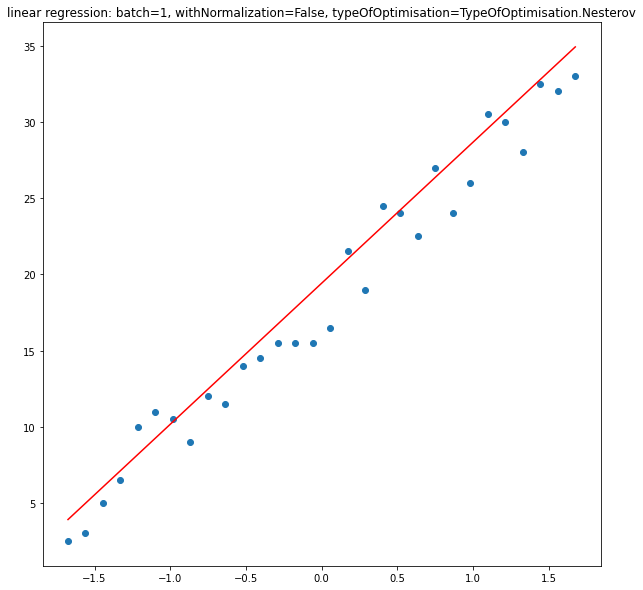

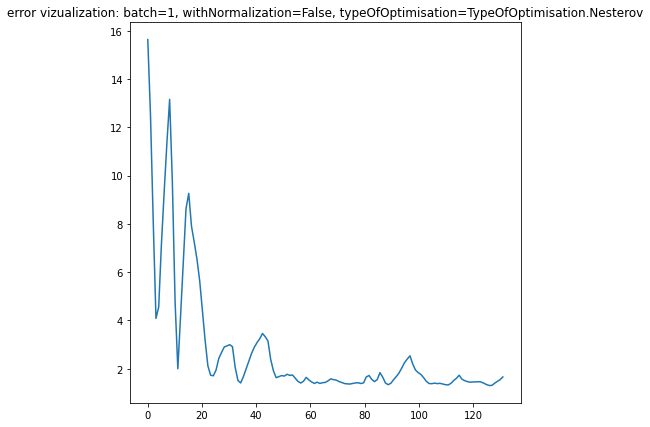

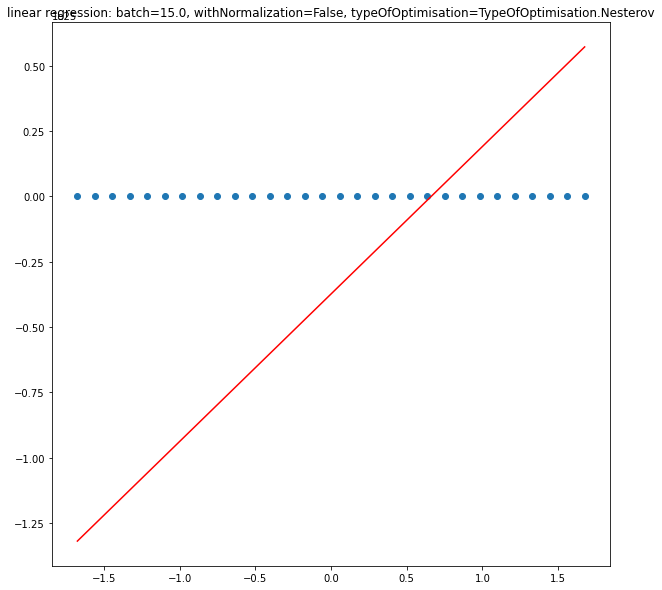

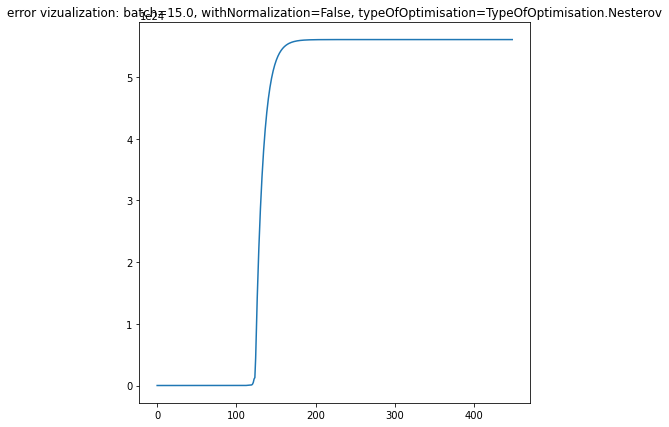

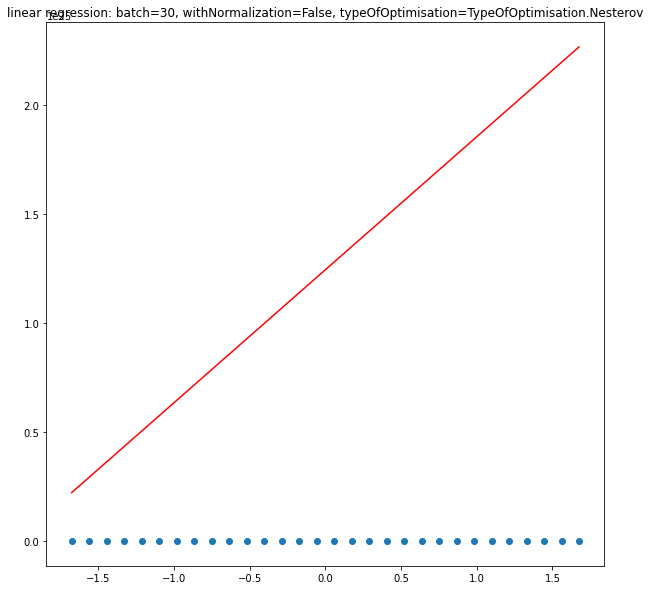

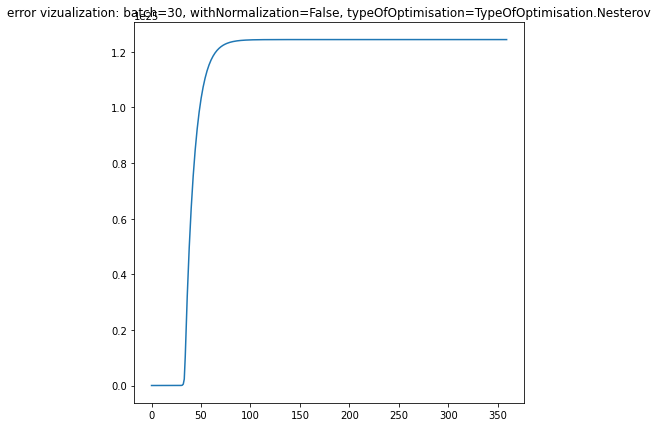

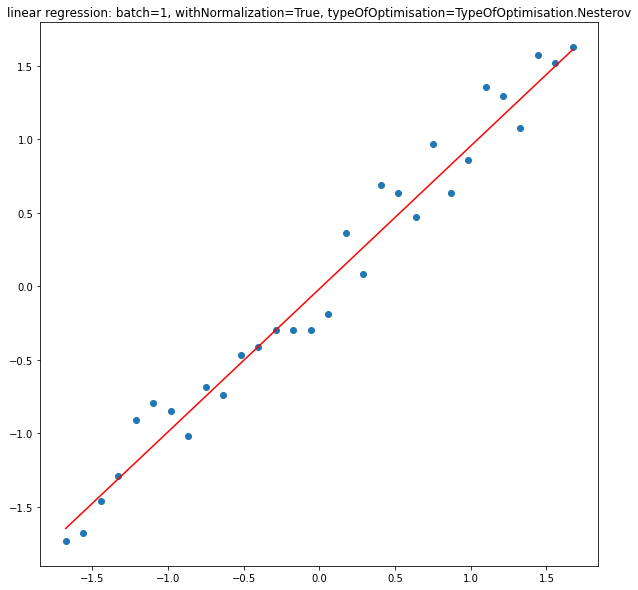

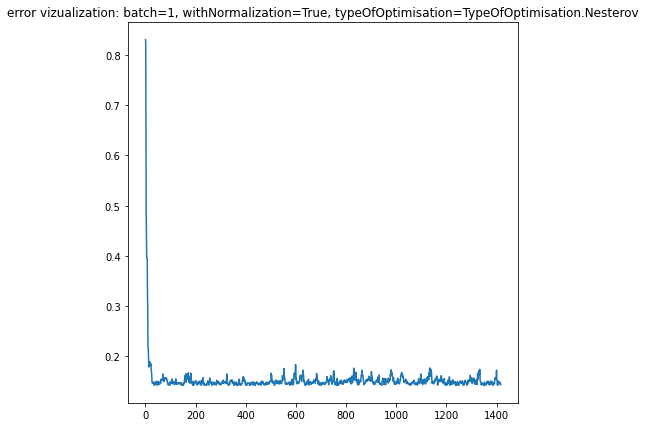

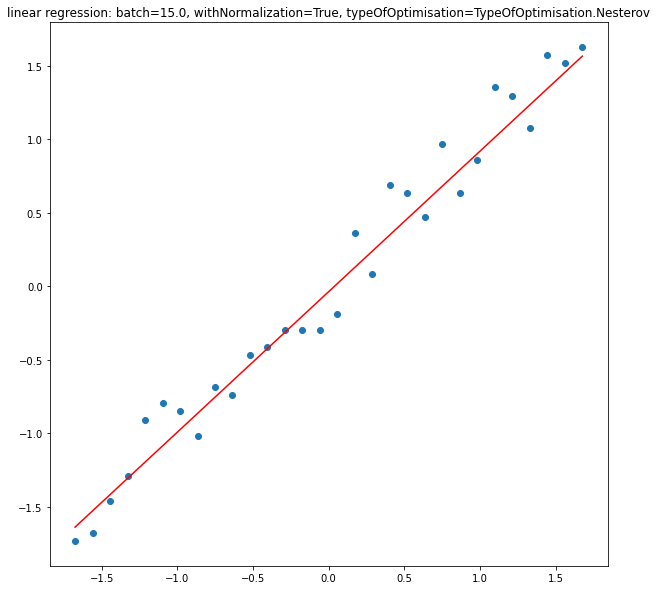

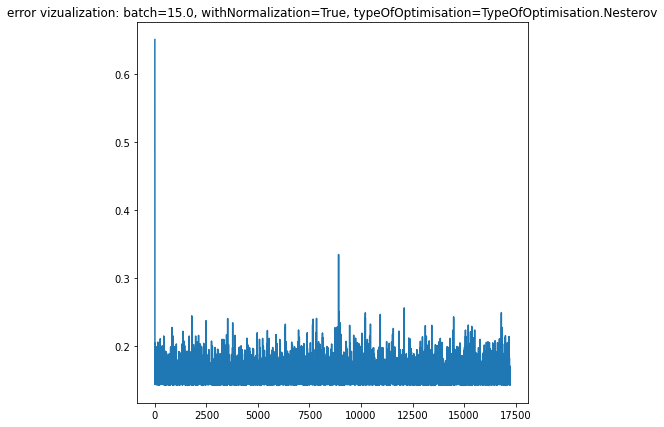

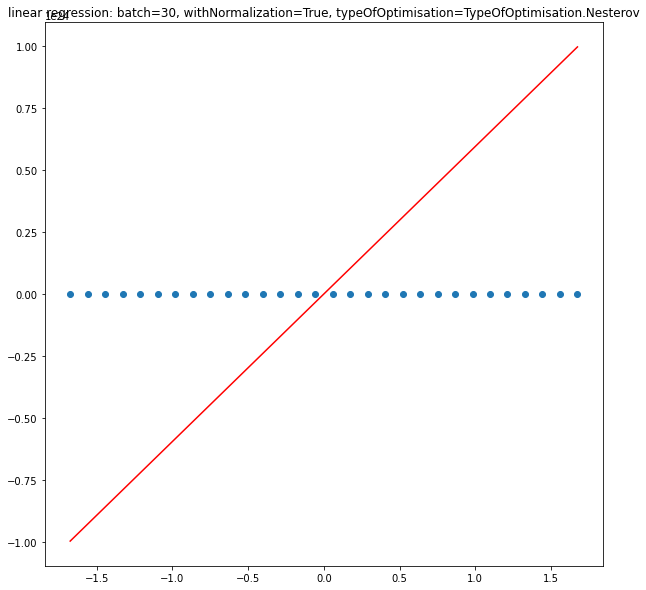

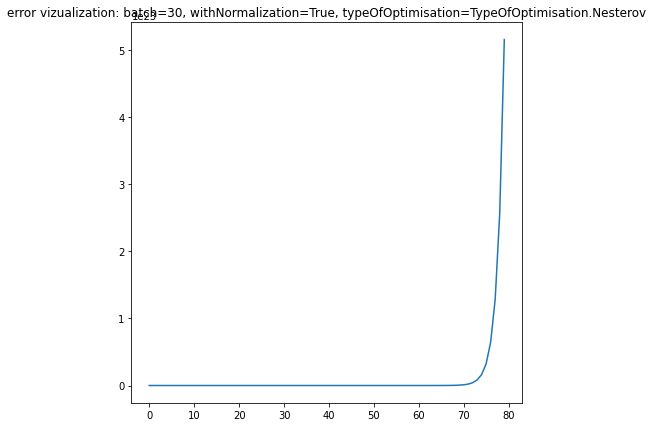

In [39]:
%memit runSGD(1, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M / 2, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)

### AdaGrad

Некоторые параметры могут быстрее достигать своего оптимума. То есть те параметры, которые близки к оптимуму,
нужно менять с меньшим шагом, а другие с большим.


batch:                    1
18.133333354144977 1.4227569263342792
actual coefficients:      [4. 1.]
calculated coefficients:  [18.81380537  9.53368281]
number of iterations:     314
number of calculations:  1260
execution time:  74.6150016784668 ms
peak memory: 121.20 MiB, increment: 0.00 MiB

batch:                    15.0
18.133333333410835 1.3097643338863056
actual coefficients:      [4. 1.]
calculated coefficients:  [18.18761581  8.78197165]
number of iterations:     785
number of calculations:  25152
execution time:  196.58708572387695 ms
peak memory: 124.18 MiB, increment: 2.98 MiB

batch:                    30
18.133333333350045 1.302985134190584
actual coefficients:      [4. 1.]
calculated coefficients:  [18.22637931  8.97745312]
number of iterations:     187
number of calculations:  11656
execution time:  76.49517059326172 ms
peak memory: 124.04 MiB, increment: 0.00 MiB

batch:                    1
0.8114296986581356 0.15179625875703173
actual coefficients:      [ 1. -1.]
cal

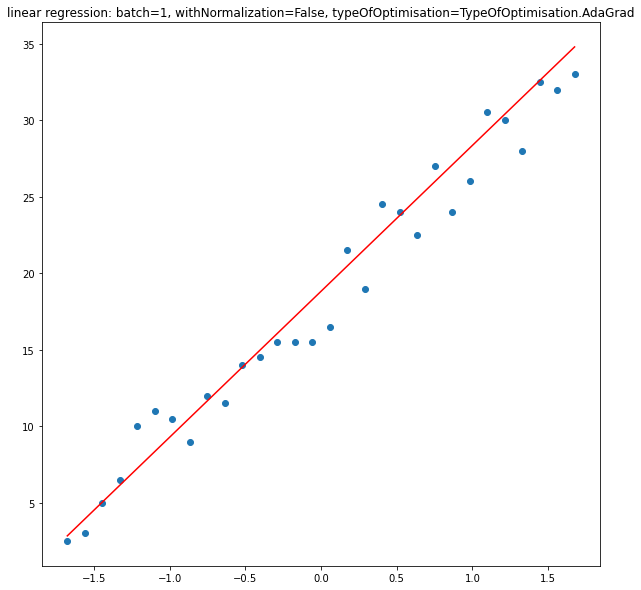

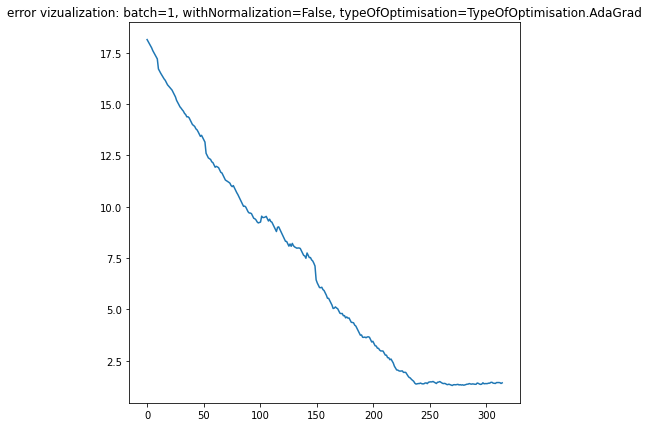

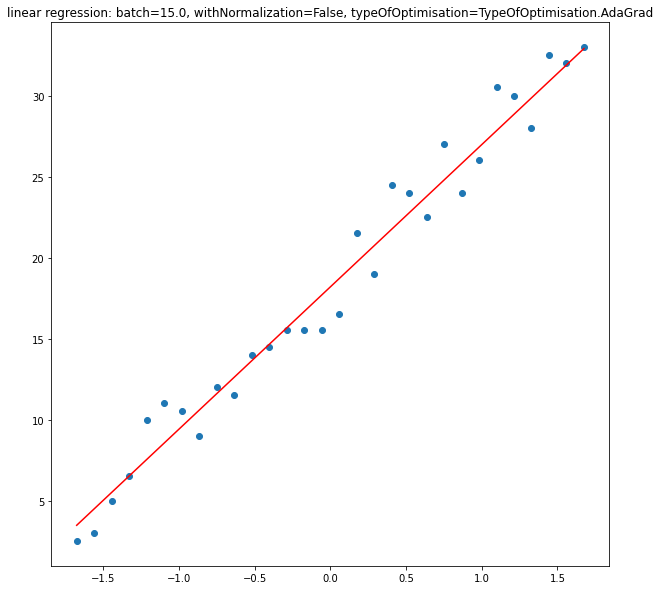

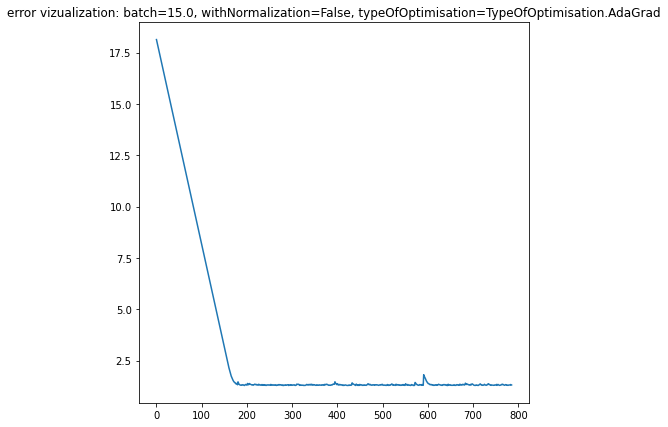

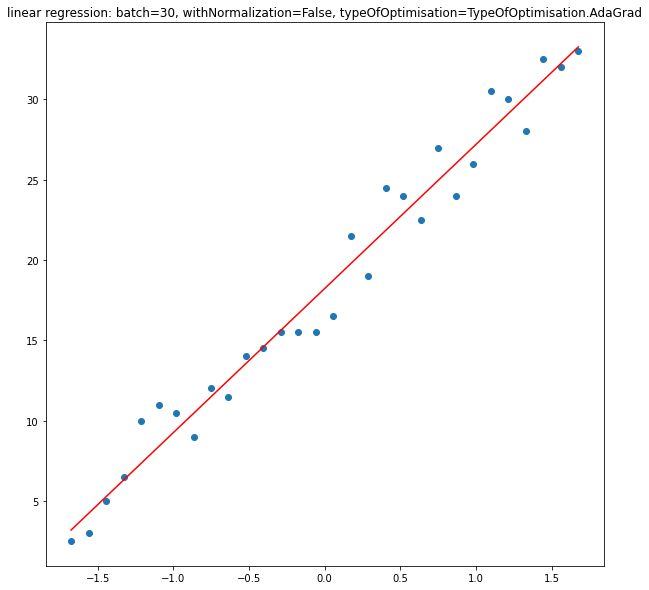

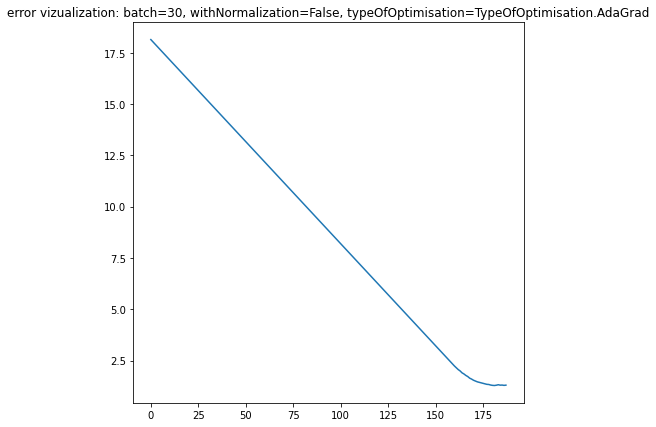

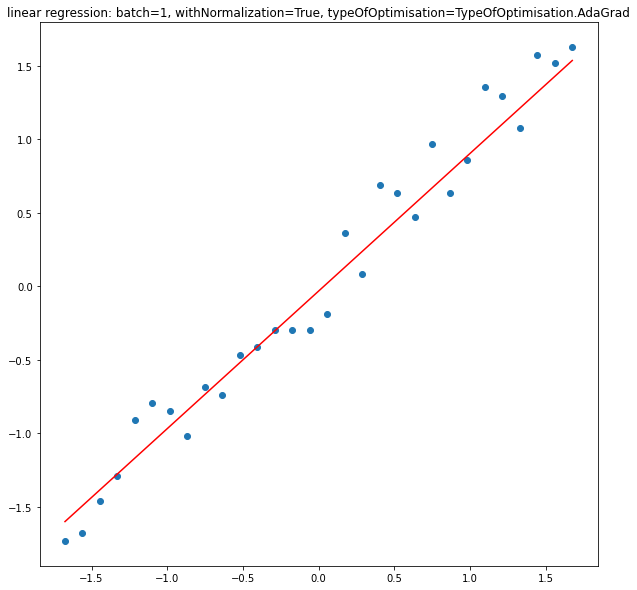

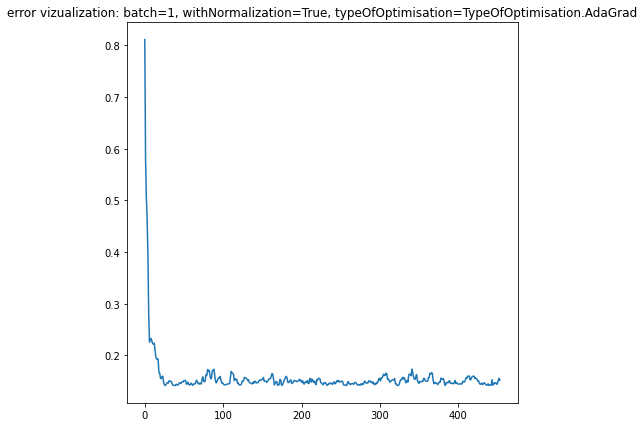

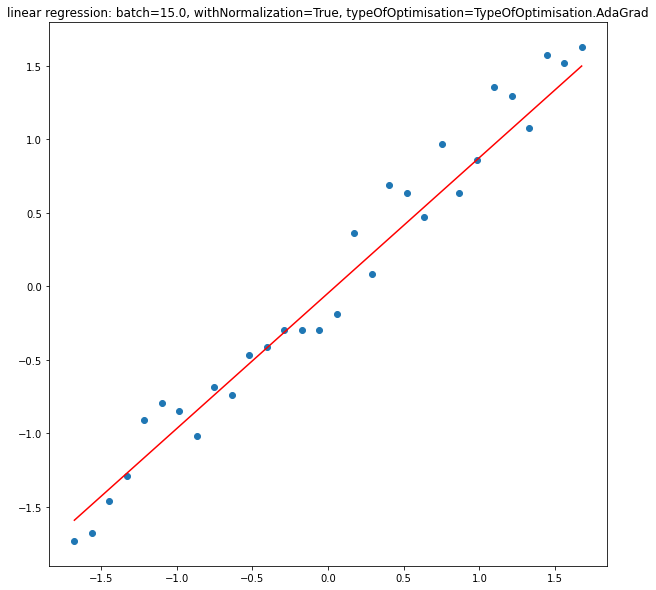

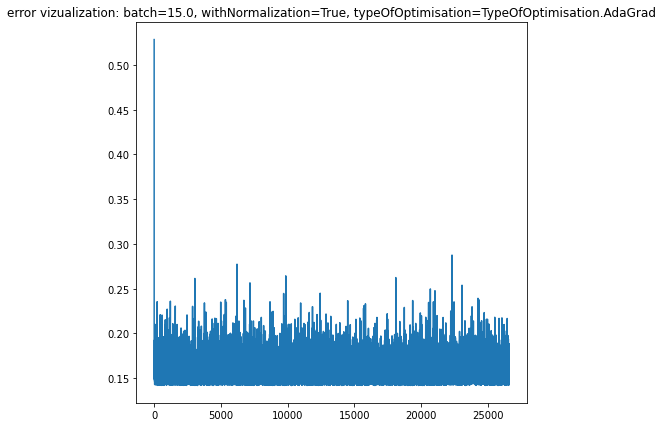

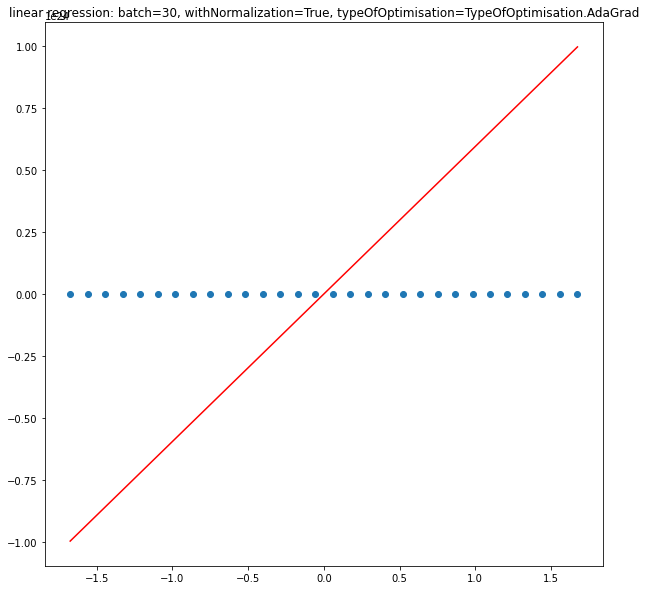

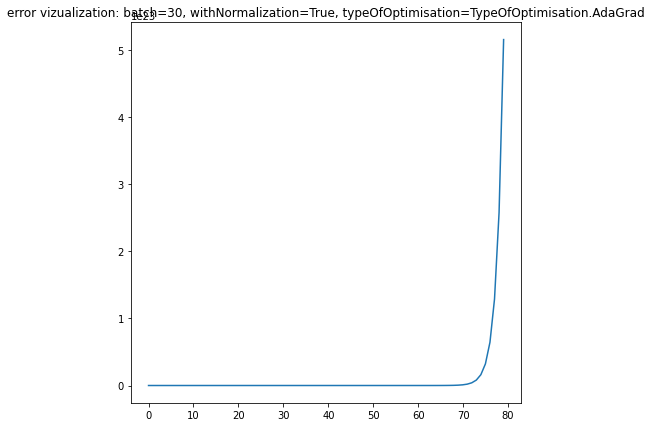

In [40]:
%memit runSGD(1, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M / 2, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)

### RMSProp

Идея сохранять не всю историю по квадратам градиеента, а только часть. Использовать дисконтирующий множитель,
чтобы ограничеть действие далеких градиентов, вычесленных давно.


batch:                    1
17.917105784207745 9.849893461713515
actual coefficients:      [4. 1.]
calculated coefficients:  [9.52788896 0.65685539]
number of iterations:     31
number of calculations:  128
execution time:  10.310173034667969 ms
peak memory: 124.01 MiB, increment: 0.00 MiB

batch:                    15.0
17.917105570204104 1.3540616799196519
actual coefficients:      [4. 1.]
calculated coefficients:  [18.10861165  8.60831011]
number of iterations:     1299
number of calculations:  41600
execution time:  347.2449779510498 ms
peak memory: 127.22 MiB, increment: 3.21 MiB

batch:                    30
17.917105567844935 1.3150811739020896
actual coefficients:      [4. 1.]
calculated coefficients:  [18.31534287  8.98339103]
number of iterations:     116
number of calculations:  7254
execution time:  53.369998931884766 ms
peak memory: 124.68 MiB, increment: 0.00 MiB

batch:                    1
0.6914833551686771 0.14490170877887412
actual coefficients:      [ 1. -1.]
calcu

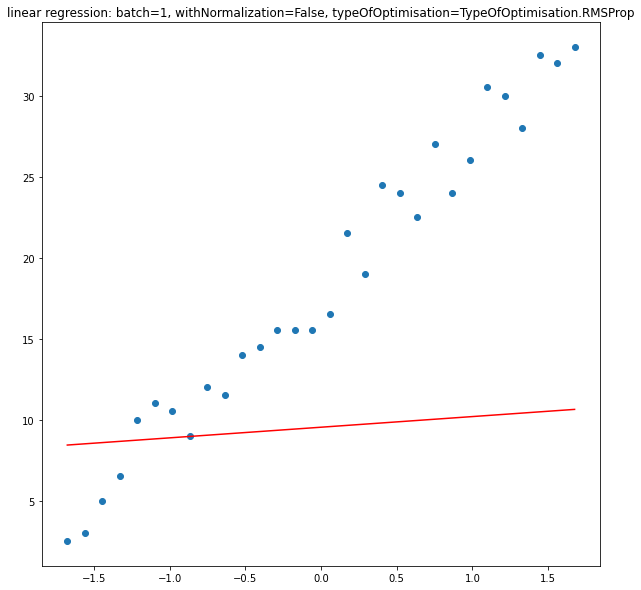

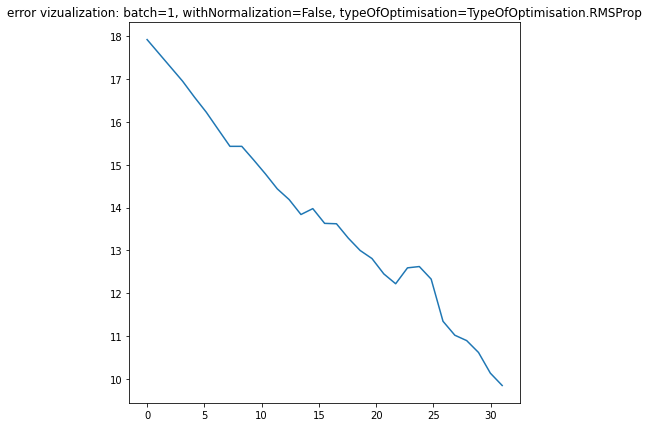

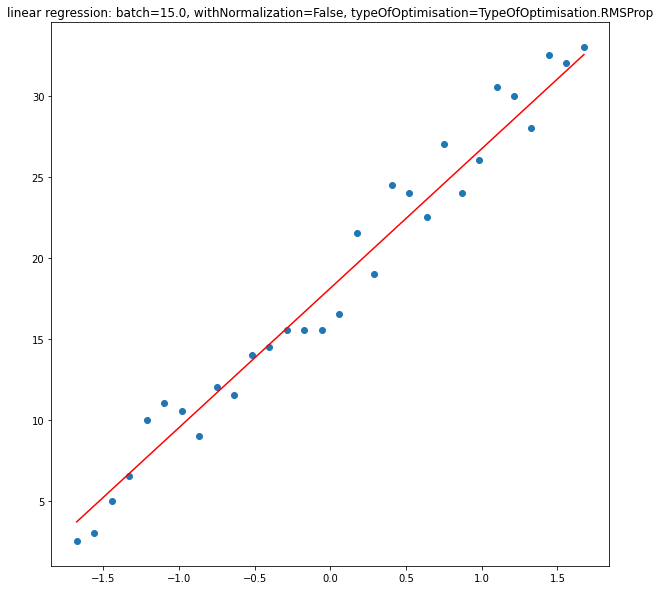

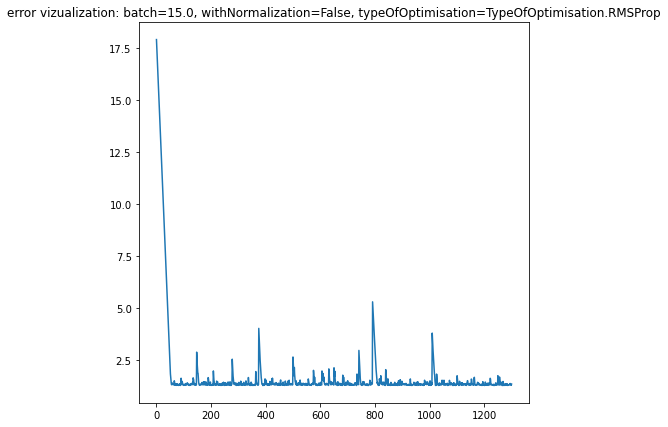

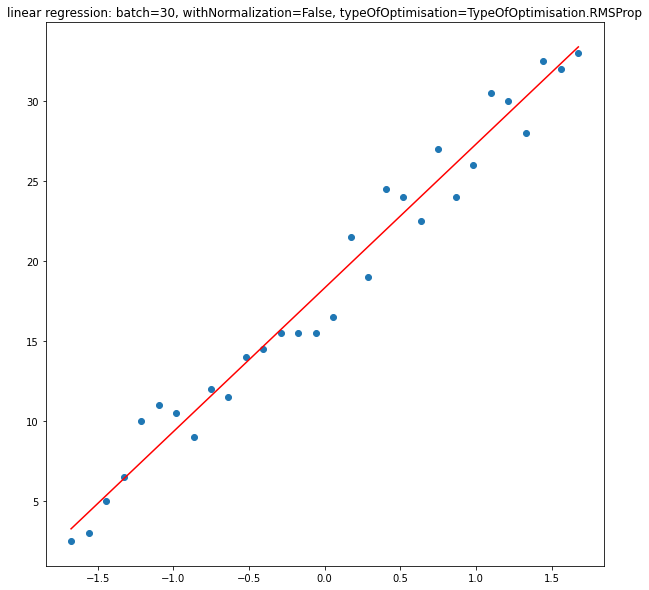

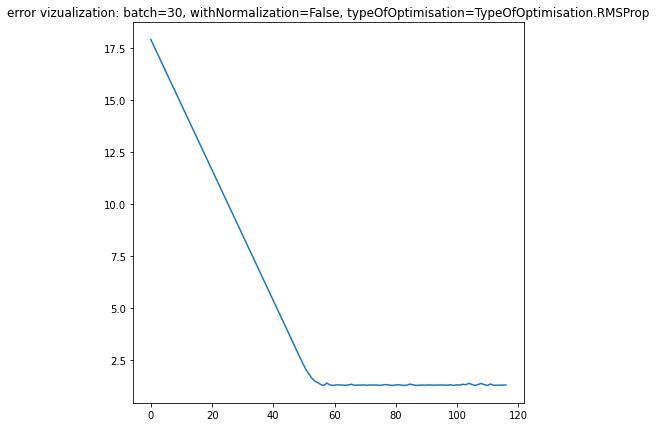

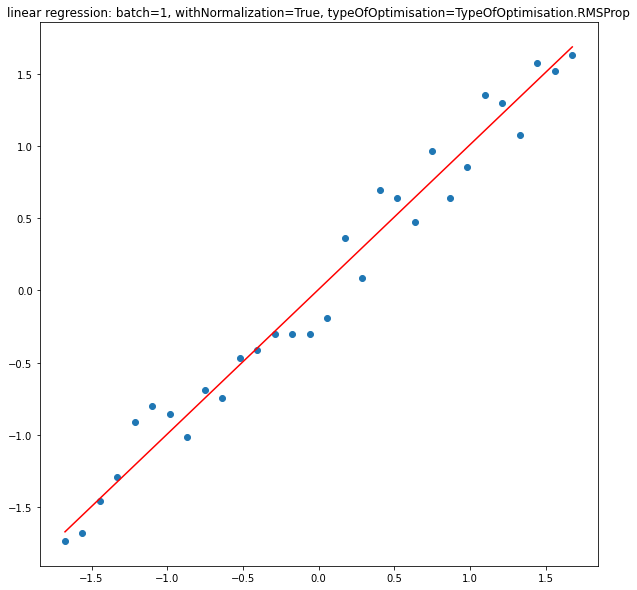

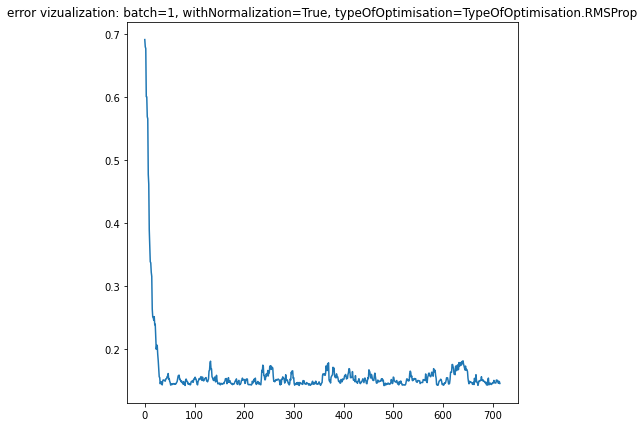

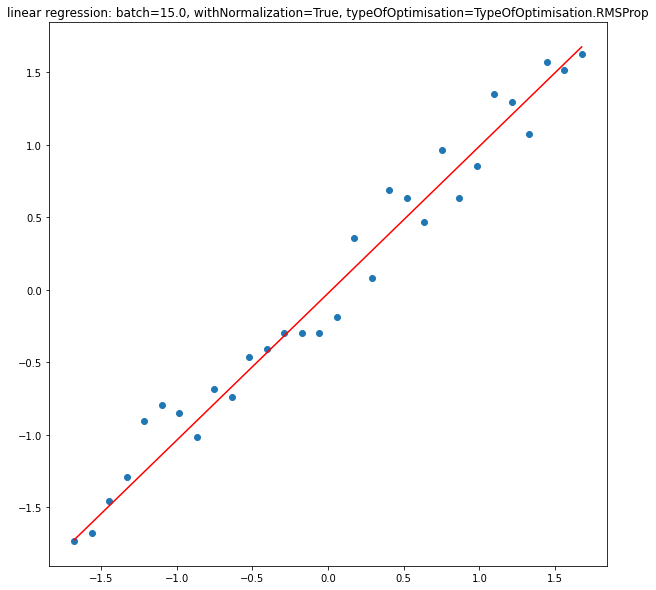

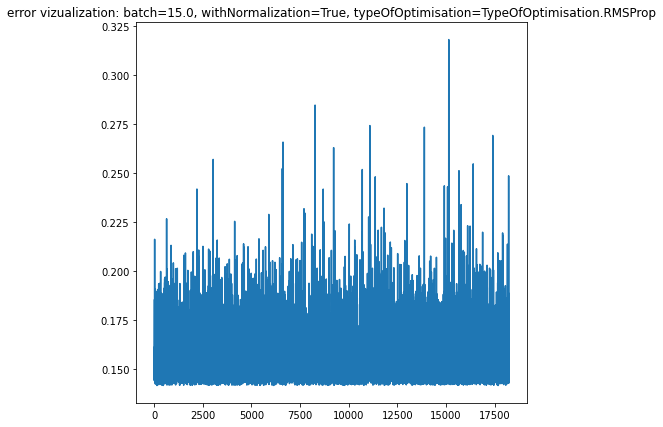

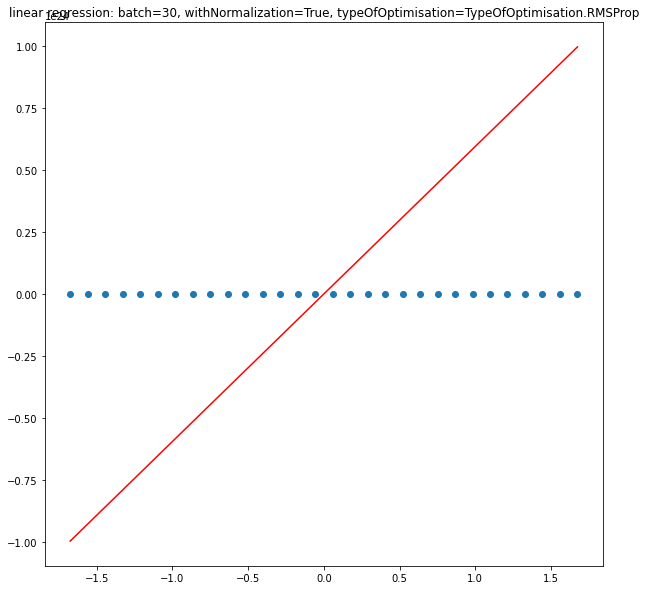

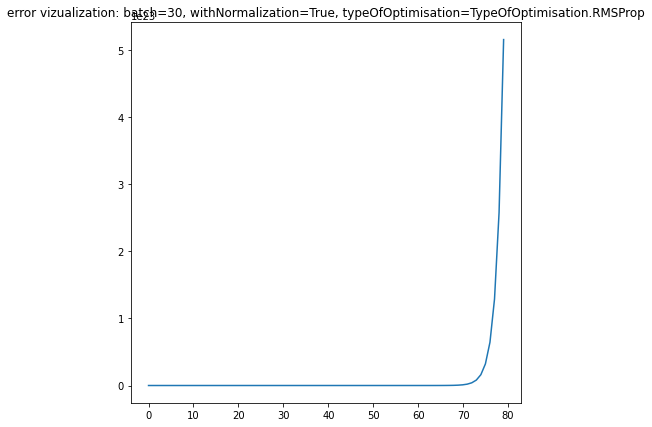

In [41]:
%memit runSGD(1, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M / 2, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)


### Adam

Фактически, этот алгоритм является очередной модификацией алгоритма Adagrad, 
использующий сглаженные версии среднего и среднеквадратического градиентов


batch:                    1
18.133333533332735 1.3811471975717622
actual coefficients:      [4. 1.]
calculated coefficients:  [17.87145966  8.49124916]
number of iterations:     443
number of calculations:  3108
execution time:  101.48787498474121 ms
peak memory: 126.21 MiB, increment: 0.00 MiB

batch:                    15.0
18.13333333338503 1.287941924234373
actual coefficients:      [4. 1.]
calculated coefficients:  [18.01278068  8.94864555]
number of iterations:     426
number of calculations:  14945
execution time:  128.8001537322998 ms
peak memory: 126.21 MiB, increment: 0.00 MiB

batch:                    30
18.133333333350045 1.2850723024353488
actual coefficients:      [4. 1.]
calculated coefficients:  [18.0635162   8.93657481]
number of iterations:     446
number of calculations:  29055
execution time:  186.3389015197754 ms
peak memory: 126.21 MiB, increment: 0.00 MiB

batch:                    1
0.7196543452974616 0.15273951948984035
actual coefficients:      [ 1. -1.]
cal

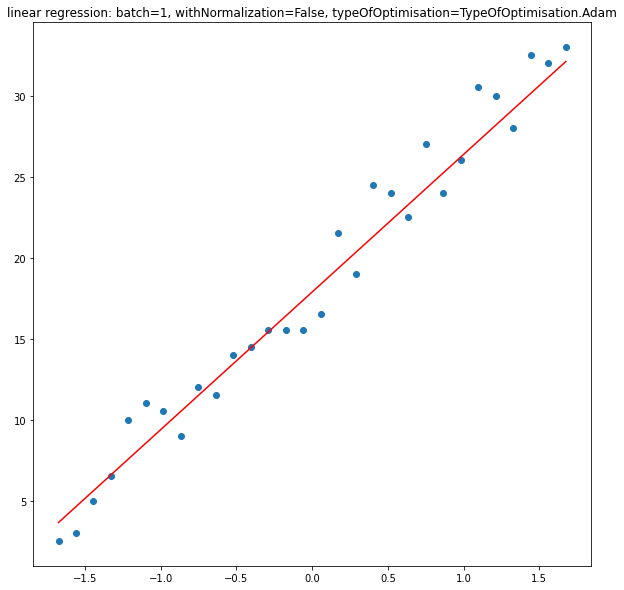

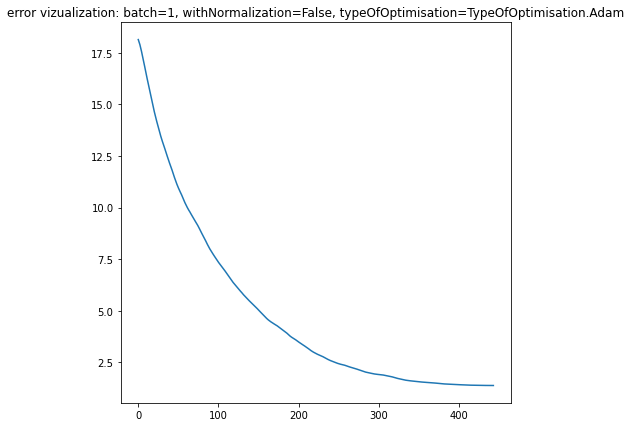

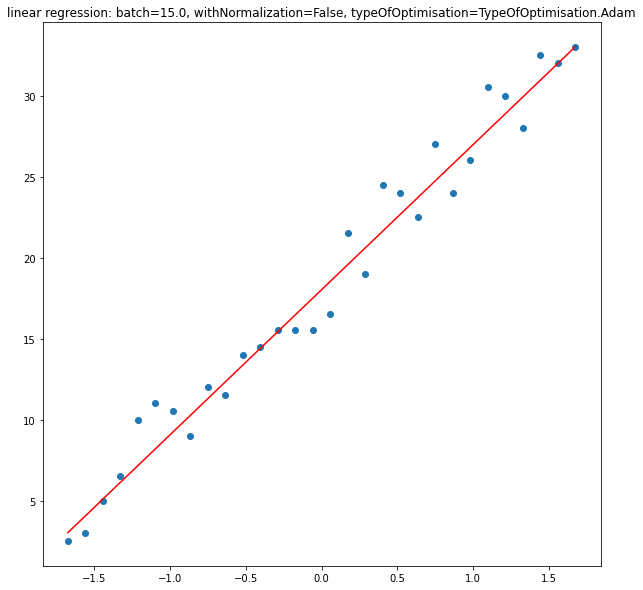

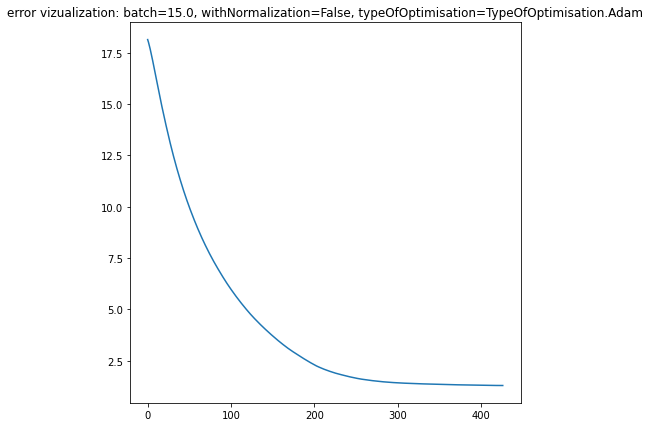

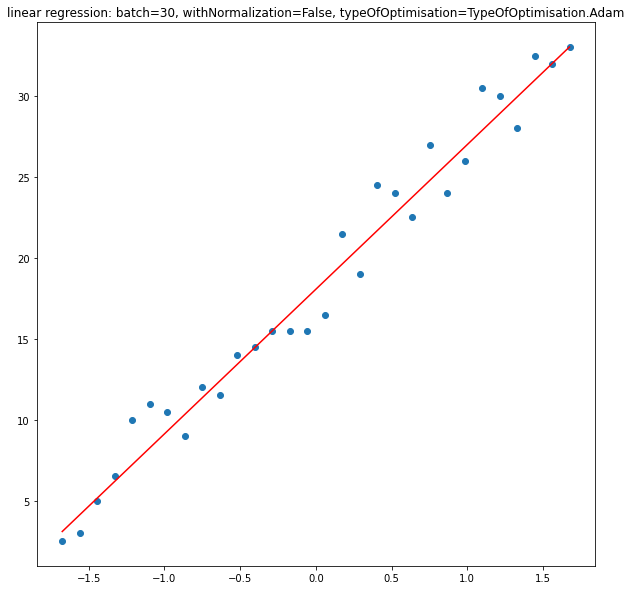

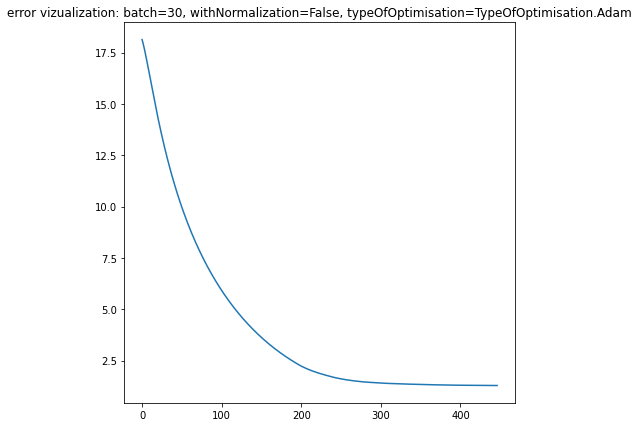

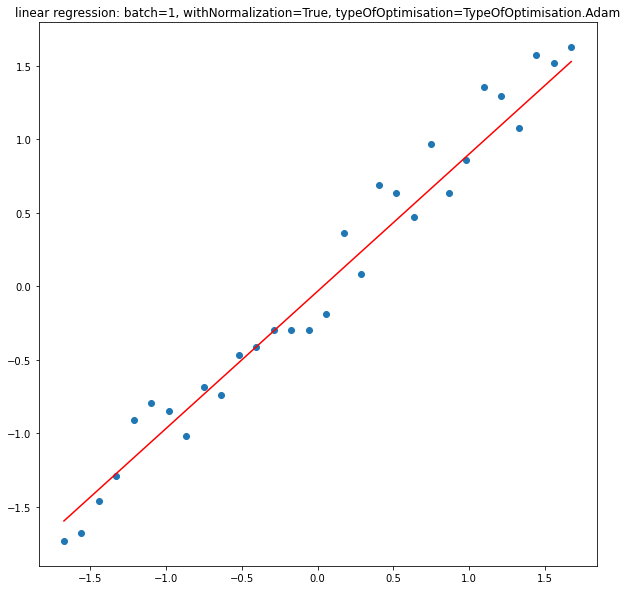

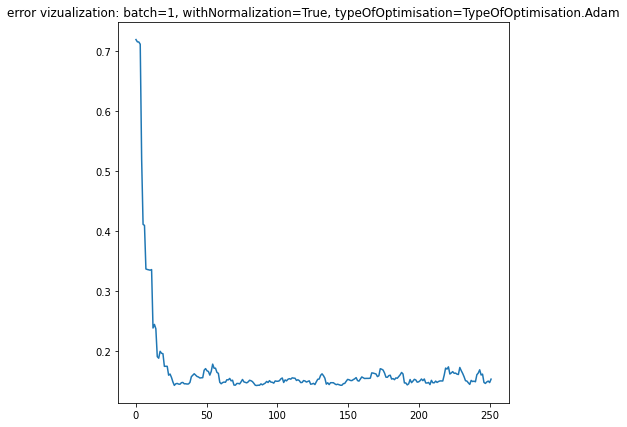

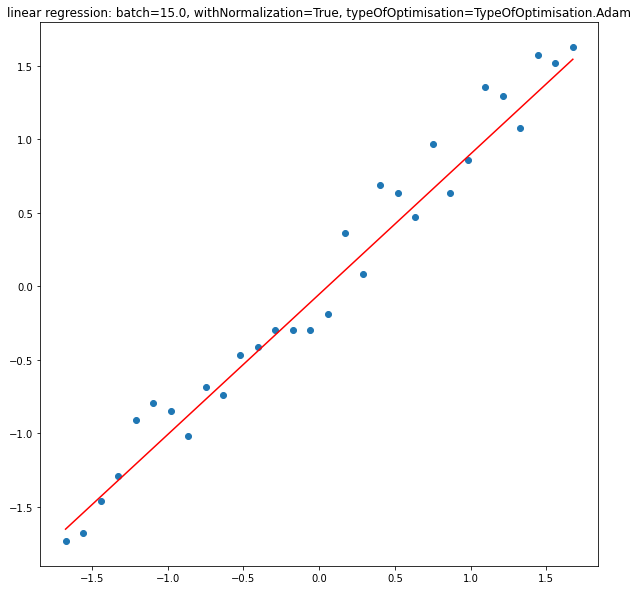

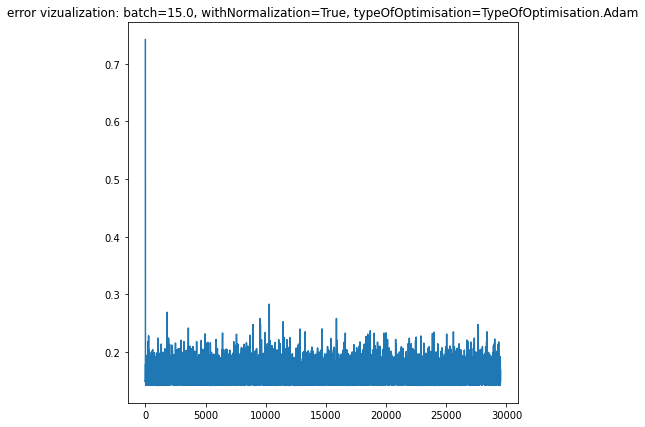

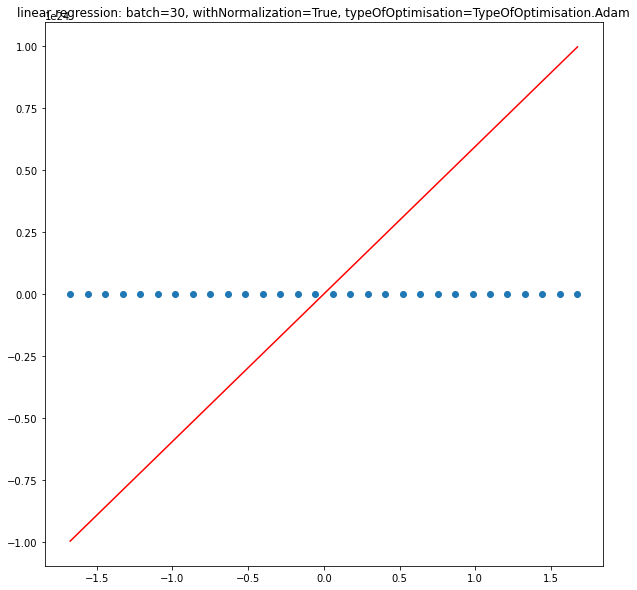

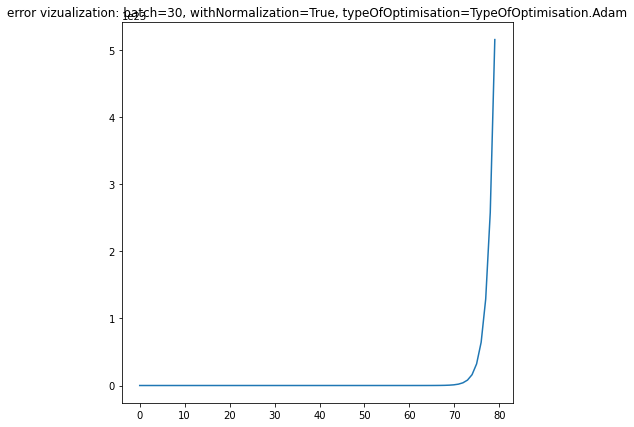

In [42]:
%memit runSGD(1, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M / 2, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)

